In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pickle
import tqdm
import time
import math

from keras.models import Sequential
from keras.layers import Dense
import keras
from IPython.display import clear_output

from random import choice

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.semilogy(self.x, self.losses, label="loss")
        plt.semilogy(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [2]:
f = h5py.File('second_sample.hdf5','r')

print(f.keys())
print(f['data'].attrs.keys())
print(f['data'].attrs['title'])
print(f['data'].attrs['descr'])
print(f['data'].attrs['columns'])

rawdata = np.copy(f['data'])
f.close()

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['N', 'columns', 'descr', 'title']>
First fake dataset
Here is where we can leave notes on how we made the data set...
0-2047: wavenumber, 2048-4095: flux, z, Nar_fwhm, BLR_fwhm, BLR_fl,Nar_fl,NII_fl,Cont,Type


In [3]:
rawdata.shape

(100000, 4104)

In [4]:
freq =   rawdata[:,   0:2048]
flux =   rawdata[:,2048:4096]
opzs = 1+rawdata[:,4096]

In [5]:
### Define function that turns the edges of the wavelengths and 
### number of samples and position into (1+z) under the assumption it was HII

def con_pos2opz(index, leftedge,rightedge,num):
    return (index/num*(rightedge-leftedge)+leftedge)/(6562.8/1e4)

def con_opz2pos(opz, leftedge,rightedge,num):
    return (opz*(6562.8/1e4)-leftedge)/(rightedge-leftedge)*num



In [6]:
peakwl = opzs*(6562.8/1e4)

In [7]:
peakwl

array([1.73518116, 2.11997757, 2.26893987, ..., 1.7754702 , 2.28432142,
       2.12268928])

In [94]:
freq[:,0]

array([1.42533, 1.92543, 1.92543, ..., 1.42533, 1.92543, 1.92543])

In [95]:
mask000 = (freq[:,0]< 1.5)
mask001 = (freq[:,0]> 1.5)

In [99]:
print(np.sum(mask000*1.0),np.sum(mask001*1.0),np.sum(mask000*1.0)+np.sum(mask001*1.0))

43343.0 56657.0 100000.0


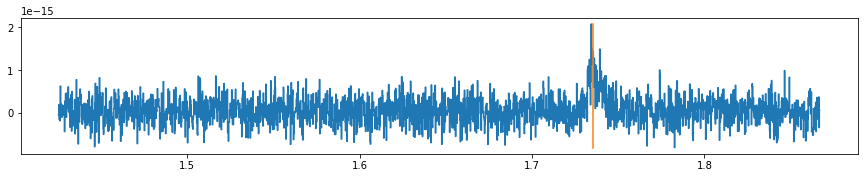

In [8]:
toshow = 1
offset = 0
plt.figure(figsize=(15,2.5*toshow))
for i in range(offset,offset+toshow):
    plt.subplot(toshow,1,i+1-offset)
    plt.plot(freq[i],flux[i],drawstyle='steps-mid')
    guess = int(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048))
    plt.plot([freq[i,guess],freq[i,guess]],[np.min(flux[i]),np.max(flux[i])])
plt.show()

## First make a rough guess on z by looking for the maximum and then bind a window around it.

### First check this is not too wrong

In [9]:
## I am going to soften the flux, that way I can remove the spurious maxima

softflux7 = np.zeros_like(flux)
softflux3 = np.zeros_like(flux)

for i in tqdm.tqdm(range(len(flux))):
    softflux7[i] = np.convolve(flux[i],np.ones(7)/7,'same')
    softflux3[i] = np.convolve(flux[i],np.ones(3)/3,'same')

100%|██████████| 100000/100000 [00:07<00:00, 13260.16it/s]


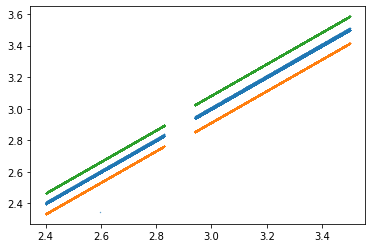

In [10]:
opz_guess3 = con_pos2opz(np.argmax(softflux3,axis=1),freq[:,0],freq[:,-1],2048)
opz_guess7 = con_pos2opz(np.argmax(softflux7,axis=1),freq[:,0],freq[:,-1],2048)

## These show the window that of 200 pixels in each direction...
opz_guess_l = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)-200,freq[:,0],freq[:,-1],2048)
opz_guess_h = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)+200,freq[:,0],freq[:,-1],2048)

plt.scatter(opzs,opz_guess3,s=0.1)
plt.scatter(opzs,opz_guess_l,s=0.01)
plt.scatter(opzs,opz_guess_h,s=0.01)
#plt.scatter(opzs,opz_guess_h,s=0.1)

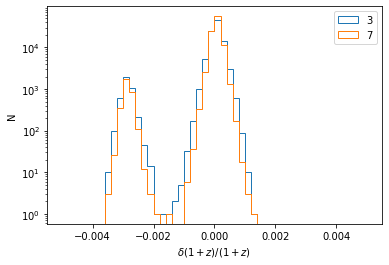

99999.0
100000.0


In [11]:
## Another way to see this:

k3 = plt.hist((opzs-opz_guess3)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='3')
k5 = plt.hist((opzs-opz_guess7)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='7')
plt.legend()
plt.yscale('log')
plt.ylabel('N')
plt.xlabel(r'$\delta (1+z)/(1+z)$')
plt.show()
print(np.sum(k3[0]))
print(np.sum(k5[0]))

## Now that we have a good rough knowledge of z, we can choose a window. And rescale...

In [12]:
nconvert = len(rawdata)
#nconvert = 20
window = 200
wfreq = np.zeros((nconvert,int(2*window+1)))
wflux = np.zeros((nconvert,int(2*window+1)))
wpos_tr = np.zeros(nconvert)
wpos_gs = np.zeros(nconvert)
wshift = np.zeros(nconvert)

for i in tqdm.tqdm(range(nconvert)):       
    posc_o = int(np.round(con_opz2pos(opz_guess7[i],freq[i,0],freq[i,-1],2048)))
    posc_true = int(np.round(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048)))
    posc = np.min([np.max([window,posc_o]),2047-window])
    posh = posc + window
    posl = posc - window
    wshift[i] = posl
    wpos_tr[i] = int(posc_true - posl)
    wpos_gs[i] = int(posc_o - posl)
    y1 = flux[i,posl:posh+1]
    x1 = freq[i,posl:posh+1]
    
    ym = np.mean(flux[i])
    yv = np.var(flux[i])
    
    #print(posc,posl,posh,posh-posl)
    wflux[i] = (y1-ym)/np.sqrt(yv)
    wfreq[i] = x1   

100%|██████████| 100000/100000 [00:16<00:00, 5999.69it/s]


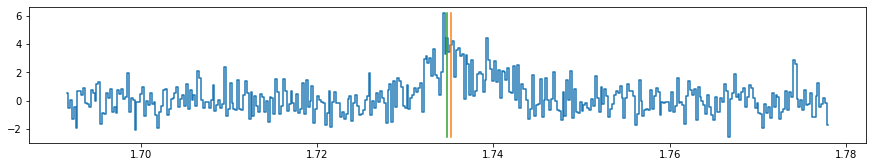

In [13]:
## Let us have a look
toshow = 1
offset = 0
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    plt.plot(wfreq[i+offset],wflux[i+offset],drawstyle='steps-mid')
    plt.plot([wfreq[i+offset,int(wpos_tr[i+offset])],wfreq[i+offset,int(wpos_tr[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])
    plt.plot([wfreq[i+offset,int(wpos_gs[i+offset])],wfreq[i+offset,int(wpos_gs[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])

plt.show()

# Do the thing: Use NN to try to guess z

In [16]:
wfreq.shape

(100000, 401)

In [18]:
## Split data into training and evaluation
NN = len(wfreq)

wboth = np.concatenate((wfreq[:,0].reshape((NN,1)),wfreq[:,-1].reshape((NN,1)),wflux),axis=1) 

train_frac = 0.8
train_N = int(train_frac * NN)
print(train_N)

## Define test and training data

trainx = wboth[0:train_N]
trainy = peakwl[0:train_N]

testx  = wboth[train_N:]
testy  = peakwl[train_N:]

80000


In [79]:
## Define Neural networks and compare

model_001 = Sequential()
model_001.add(Dense(400, input_dim=403, activation='relu'))
model_001.add(Dense(400, activation='relu'))
model_001.add(Dense(400, activation='relu'))
model_001.add(Dense(400, activation='relu'))
model_001.add(Dense(20, activation='relu'))
model_001.add(Dense(1))
model_001.compile(loss='mean_squared_error', optimizer='adam')

In [80]:
model_001.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 400)               161600    
_________________________________________________________________
dense_28 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_29 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_30 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_31 (Dense)             (None, 20)                8020      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 21        
Total params: 650,841
Trainable params: 650,841
Non-trainable params: 0
________________________________________________

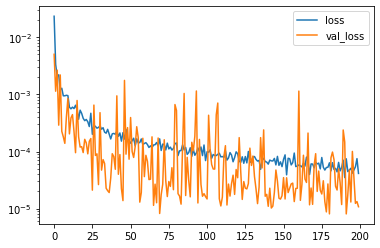

done with 001


In [81]:
## Run the damned training sessions

history_001 = model_001.fit(trainx, trainy, epochs=200, verbose=1,\
                            shuffle=True, validation_split=0.1,callbacks=[plot_losses])
print("done with 001")

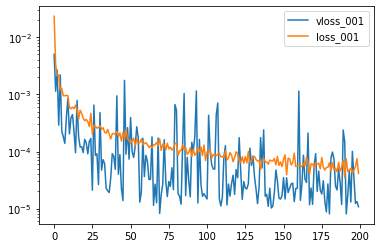

In [87]:
## Shows the history of convergence...

plt.semilogy(history_001.history['val_loss'],label='vloss_001')
plt.semilogy(history_001.history['loss'],label='loss_001')
plt.legend()
plt.show()

In [88]:
## Evaluate Performance

testScore = model_001.evaluate(testx, testy, verbose=0)
print('Test Score (001): %.5f MSE (%.5f RMSE)' % (testScore, np.sqrt(testScore)))


Test Score (001): 0.00001 MSE (0.00341 RMSE)


In [89]:
## Used the neural network to make predictions

testPredict_001 = model_001.predict(wboth)[:,0]

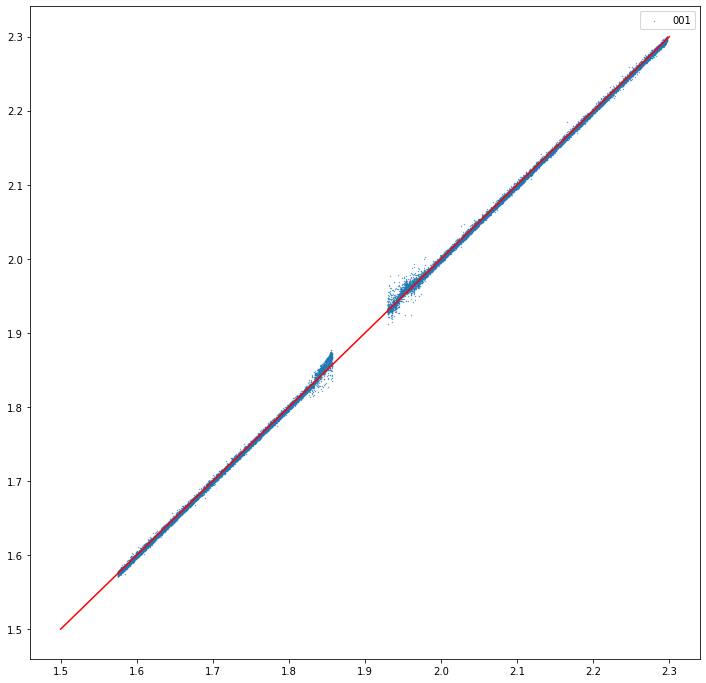

In [90]:
## This is a scatter-plot to show the prediction vs truth... 

plt.figure(figsize=(12,12))
plt.plot([1.5,2.3],[1.5,2.3],'r-')
#plt.subplot(1,3,1)
plt.scatter(peakwl[train_N:],testPredict_001[train_N:],s=0.1,label='001')
#plt.subplot(1,3,2)
#plt.scatter(wpos_tr[train_N:],testPredict_002[train_N:],s=0.1,label='002')
#plt.subplot(1,3,3)
#plt.scatter(wpos_tr[train_N:],testPredict_003[train_N:],s=0.1,label='003')
plt.legend()

plt.show()

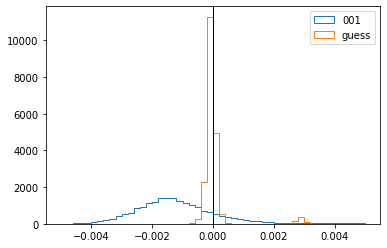

19607.0


In [91]:
mybins=np.linspace(-0.005,0.005,51)



acc_001 = (testPredict_001[train_N:]-0.0018-peakwl[train_N:])/peakwl[train_N:]
acc_guess = (opz_guess7[train_N:]-opzs[train_N:])/opzs[train_N:]

k1 = plt.hist(acc_001,bins=mybins,histtype='step',label='001')
k2 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
#plt.yscale('log')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.show()
print(np.sum(k1[0]))
